### Read the Data

In [1]:
# Import Libraries
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, TFBertModel
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf

In [2]:
import pandas as pd
import ast

# Read data from CSV
file_path = '/kaggle/input/suicidal-dataset/clean_dataset.csv'
df = pd.read_csv(file_path)

# Convert string literals to Python lists
df['text'] = df['text'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Join lists into sentences
df['text'] = df['text'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)




In [3]:
df.head()

,Unnamed: 0,text,class
0,2,ex wife threaten suicide recently leave wife g...,suicide
1,3,weird get affect li come someone know feel rea...,non-suicide
2,4,finally almost never hear bad year ever swear ...,non-suicide
3,8,need help help cry hard,suicide
4,9,lose hello name struggle year afraid past year...,suicide


## Modelling

### Tokenization

In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import gensim.downloader as api
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Embedding, Dropout, Dense
from keras.layers import GRU
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout, Bidirectional, Input

# Configuration
EMBEDDING_DIM = 100  # Dimension of word embeddings
MAX_NUM_WORDS = 20000  # Maximum number of unique words
MAX_SEQUENCE_LENGTH = 200  # Fixed sequence length for all input data

# Combine tokens back into a string to process with the Tokenizer
df['text'] = df['text'].apply(lambda tokens: " ".join(tokens))

# Tokenizer: Train and convert text to sequences
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, lower=True)  # Limit vocabulary size and convert to lowercase
tokenizer.fit_on_texts(df['text'])  # Learn the vocabulary from the text data
X = tokenizer.texts_to_sequences(df['text'])  # Convert text to numerical sequences

# Pad sequences to ensure uniform length
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH, padding='post')  # Add padding at the end of sequences


In [5]:
import pickle

# Save the tokenizer to a .pkl file
with open('tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)
print("Tokenizer has been saved to tokenizer.pkl")


Tokenizer has been saved to tokenizer.pkl


In [6]:
# Convert labels to one-hot encoding
y = pd.get_dummies(df['class']).values  # Transform class labels into a binary matrix

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# `test_size=0.3` allocates 30% of the data for testing, 70% for training
# `random_state=42` ensures reproducibility of the split

### Word Embedding

In [7]:
# Download and load pre-trained GloVe embeddings (100 dimensions)
glove_gensim = api.load('glove-wiki-gigaword-100')

# Create a weight matrix for the embedding layer
gensim_weight_matrix = np.zeros((MAX_NUM_WORDS, EMBEDDING_DIM))  # Initialize with zeros

# Populate the weight matrix with GloVe vectors for words in the tokenizer's vocabulary
for word, index in tokenizer.word_index.items():
    if index < MAX_NUM_WORDS:  # Ensure the index is within the specified maximum word limit
        if word in glove_gensim.index_to_key:  # Check if the word exists in the GloVe vocabulary
            gensim_weight_matrix[index] = glove_gensim[word]  # Assign the GloVe vector
        else:
            gensim_weight_matrix[index] = np.zeros(EMBEDDING_DIM)  # Assign a zero vector if the word is not found

[==================================================] 100.0% 128.1/128.1MB downloaded


### Model Building

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, GRU, Dense, Dropout, GlobalAveragePooling1D
from tensorflow.keras.optimizers import RMSprop

# Input layer
input_layer = Input(shape=(X.shape[1],), name="Input_Layer")

# Embedding layer with pre-trained GloVe weights
embedding_layer = Embedding(
    input_dim=MAX_NUM_WORDS,
    output_dim=EMBEDDING_DIM,
    weights=[gensim_weight_matrix],
    trainable=False,
    name="Embedding_Layer"
)(input_layer)

# Bidirectional GRU layer
bi_gru = Bidirectional(GRU(128, return_sequences=True), name="BiGRU")(embedding_layer)

# Global Average Pooling to reduce sequence dimension
gap = GlobalAveragePooling1D(name="Global_Avg_Pooling")(bi_gru)

# Fully Connected Layers
dense_1 = Dense(64, activation='relu', name="Dense_Layer_1")(gap)
dense_dropout = Dropout(0.3, name="Dense_Dropout")(dense_1)

# Output Layer
output_layer = Dense(y.shape[1], activation='sigmoid', name="Output_Layer")(dense_dropout)

# Build the Model
model = Model(inputs=input_layer, outputs=output_layer, name="Simple_BiGRU_Model")

# Compile the Model with RMSprop optimizer
model.compile(
    optimizer=RMSprop(learning_rate=0.001),  # Using RMSprop with default parameters
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Display Model Summary
model.summary()


Model: "Simple_BiGRU_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_Layer (InputLayer)        │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Embedding_Layer (Embedding)     │ (None, 200, 100)       │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BiGRU (Bidirectional)           │ (None, 200, 256)       │       176,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Global_Avg_Pooling              │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Layer_1 (Dense)           │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Dropout (Dropout)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,193,218 (8.37 MB)

 Trainable params: 193,218 (754.76 KB)

 Non-trainable params: 2,000,000 (7.63 MB)

### Train the Model

In [9]:
from tensorflow.keras.models import load_model

# EarlyStopping and ModelCheckpoint for saving weights
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('best_model.weights.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True, save_weights_only=True)

# Train the model
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=64,
    callbacks=[es, mc]
)

# After training, load the best weights
model.load_weights('best_model.weights.h5')
print("Best weights loaded from best_model.weights.h5")

# Save the full model to .keras format
model.save('best_model.keras')
print("Full model saved as best_model.keras")

# Convert the .keras file to .h5
model.save('best_model.h5', save_format='h5')
print("Full model saved as best_model.h5")


Epoch 1/50
2537/2539 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7595 - loss: 0.5198
Epoch 1: val_accuracy improved from -inf to 0.84360, saving model to best_model.weights.h5
2539/2539 ━━━━━━━━━━━━━━━━━━━━ 77s 29ms/step - accuracy: 0.7596 - loss: 0.5198 - val_accuracy: 0.8436 - val_loss: 0.3578
Epoch 2/50
2539/2539 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8674 - loss: 0.3271
Epoch 2: val_accuracy improved from 0.84360 to 0.86938, saving model to best_model.weights.h5
2539/2539 ━━━━━━━━━━━━━━━━━━━━ 73s 29ms/step - accuracy: 0.8674 - loss: 0.3271 - val_accuracy: 0.8694 - val_loss: 0.3167
Epoch 3/50
2537/2539 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8907 - loss: 0.2761
Epoch 3: val_accuracy improved from 0.86938 to 0.88745, saving model to best_model.weights.h5
2539/2539 ━━━━━━━━━━━━━━━━━━━━ 73s 29ms/step - accuracy: 0.8907 - loss: 0.2761 - val_accuracy: 0.8875 - val_loss: 0.2778
Epoch 4/50
2537/2539 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9014 - loss: 0.2545
Ep

### Model Evaluation

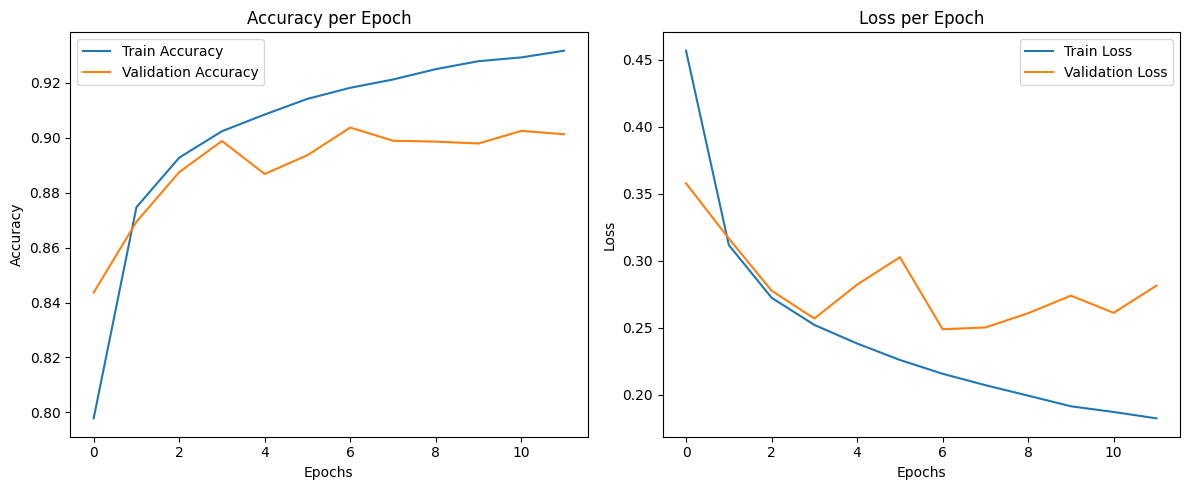

In [10]:
import matplotlib.pyplot as plt

# Plot for accuracy
plt.figure(figsize=(12, 5))

# Subplot for accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')  # Training accuracy
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')  # Validation accuracy
plt.title('Accuracy per Epoch')  # Title of the plot
plt.xlabel('Epochs')  # X-axis label
plt.ylabel('Accuracy')  # Y-axis label
plt.legend()  # Display legend

# Subplot for loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')  # Training loss
plt.plot(history.history['val_loss'], label='Validation Loss')  # Validation loss
plt.title('Loss per Epoch')  # Title of the plot
plt.xlabel('Epochs')  # X-axis label
plt.ylabel('Loss')  # Y-axis label
plt.legend()  # Display legend

# Display the plot
plt.tight_layout()  # Adjust layout for better fit
plt.show()  # Show the plots

In [11]:
from sklearn.metrics import classification_report

# Get model predictions
y_pred = model.predict(X_test)

# Convert predictions and labels from one-hot encoding to integer labels
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Generate the classification report
report = classification_report(y_test_labels, y_pred_labels, target_names=df['class'].unique())

# Print the classification report
print(report)

2176/2176 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step
              precision    recall  f1-score   support

     suicide       0.91      0.90      0.90     34824
 non-suicide       0.90      0.91      0.90     34799

    accuracy                           0.90     69623
   macro avg       0.90      0.90      0.90     69623
weighted avg       0.90      0.90      0.90     69623

